# Descriptive statistics - Observed (EO) and earliest estimated epidemic onset (EEEO) maps

- Project:     cercospoRa
- Script:      05_desc_stats_eo_cercospoRa.ipynb
- Author:      Rene Heim
- Affiliation: University of Goettingen
- Date:        2025-11-22

**Objective:** This notebook provides descriptive statistics of EO and EEEO maps to understand the distribution and characteristics of epidemic onset.

**Data:** EO and EEEO maps were generated using the cercospoRa model.

**Methods:** This notebook will explore the following aspects of the EO and EEEO maps:

* Distribution of LAI values
* Summary statistics (e.g., mean, median, standard deviation)

**Notebook Structure:** This notebook is organized into the following sections:

1. Data Import and Preparation
2. Descriptive Statistics

### 1. Set up environment

**Note:** For reproducible installation of dependencies using `%conda install`, please open this notebook in Jupyter Notebook or JupyterLab. Magic commands may not function as expected in other Python environments or editors.


In [1]:
%conda install numpy pandas geopandas rasterio rioxarray shapely matplotlib seaborn session-info2

Jupyter detected...
3 channel Terms of Service accepted
Channels:
 - defaults
Platform: win-64
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.




==> WARNING: A newer version of conda exists. <==
    current version: 25.5.1
    latest version: 25.11.0

Please update conda by running

    $ conda update -n base -c defaults conda




In [2]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import numpy as np
import geopandas as gpd
import rioxarray as rxr
import pandas as pd
from shapely.geometry import Point
import datetime as dt
from datetime import timedelta
from session_info2 import session_info
session_info(dependencies=True)

C:\Users\heim8\AppData\Local\Temp\ipykernel_3464\1194548195.py:14: RuntimeWarning: Failed to import dependencies for application/vnd.jupyter.widget-view+json representation. (ModuleNotFoundError: No module named 'ipywidgets')
  session_info(dependencies=True)


Package,Version
seaborn,0.13.2
matplotlib,3.10.6
numpy,2.3.3
geopandas,1.1.1
rioxarray,0.19.0
pandas,2.3.3
shapely,2.1.2
Component,Info
Python,"3.13.7 | packaged by Anaconda, Inc. | (main, Sep 9 2025, 19:54:37) [MSC v.1929 64 bit (AMD64)]"
OS,Windows-11-10.0.26100-SP0


In [3]:
os.chdir(r'C:\Users\heim8\ownCloud\01_projects\cercospoRa_share')
current_date = dt.date.today()
out = r"C:\Users\heim8\ownCloud\01_projects\cercospoRa_share\output"

### 2. Import raster and vector data

In [4]:
treated_ino = r"reproducibility_raw_data\20250504_treated_ino.gpkg"
untreated_ino = r"reproducibility_raw_data\20250504_untreated_ino.gpkg"

treated_roi = r"reproducibility_raw_data\20250504_treated_roi_diff.gpkg"
untreated_roi = r"reproducibility_raw_data\20250504_untreated_roi_diff.gpkg"

# Load the raster file
raster_s2 = r"output\Predicted_epidemic_onset\S2\Ep_onset_8.tif"  # Replace with your raster file
raster_s2s = r"output\Predicted_epidemic_onset\S2\Ep_onset_8.tif"
raster_uav = r"output\Predicted_epidemic_onset\UAV\Ep_onset_8.tif"

observed = r"output\Ep_onset_observed_new.tif"


# Load the polygon layers
treated_ino = gpd.read_file(treated_ino)
untreated_ino = gpd.read_file(untreated_ino)

treated_roi = gpd.read_file(treated_roi)
untreated_roi = gpd.read_file(untreated_roi)


s2 = rxr.open_rasterio(raster_s2)
s2s = rxr.open_rasterio(raster_s2s)
uav = rxr.open_rasterio(raster_uav)

obs = rxr.open_rasterio(observed)

print(f"⚠️ S2 raster CRS: {s2.rio.crs}")
print(f"⚠️ S2S raster CRS: {s2s.rio.crs}")
print(f"⚠️ UAV raster CRS: {uav.rio.crs}")
print(f"⚠️ Observed raster CRS: {obs.rio.crs}")

⚠️ S2 raster CRS: EPSG:32632
⚠️ S2S raster CRS: EPSG:32632
⚠️ UAV raster CRS: EPSG:4326
⚠️ Observed raster CRS: EPSG:32632


### 3. Reproject CRS

In [5]:
uav_rp = uav.rio.reproject("EPSG:32632")
obs_rp = obs.rio.reproject("EPSG:32632")

print(f"⚠️ UAV reprojected raster CRS: {uav_rp.rio.crs}")
#print(f"⚠️ Observed reprojected raster CRS: {obs_rp.rio.crs}")

⚠️ UAV reprojected raster CRS: EPSG:32632


In [6]:
treated_ino = treated_ino.to_crs(32632)
untreated_ino = untreated_ino.to_crs(32632)

treated_roi = treated_roi.to_crs(32632)
untreated_roi = untreated_roi.to_crs(32632)

print(f"⚠️ Treated inoculation area CRS: {treated_ino.crs}")
print(f"⚠️ Unreated inoculation area CRS: {untreated_ino.crs}")

print(f"⚠️ Treated ROI CRS: {treated_roi.crs}")
print(f"⚠️ Untreated ROI CRS: {untreated_roi.crs}")

⚠️ Treated inoculation area CRS: EPSG:32632
⚠️ Unreated inoculation area CRS: EPSG:32632
⚠️ Treated ROI CRS: EPSG:32632
⚠️ Untreated ROI CRS: EPSG:32632


### 4. Handle no data values

In [7]:
print(f"⚠️ UAV no data value is: {uav_rp.rio.nodata}")
print(f"⚠️ S2 no data value is: {s2.rio.nodata}")
print(f"⚠️ S2S no data value is: {s2s.rio.nodata}")
print(f"⚠️ Obs no data value is: {obs.rio.nodata}")

⚠️ UAV no data value is: nan
⚠️ S2 no data value is: nan
⚠️ S2S no data value is: nan
⚠️ Obs no data value is: -738245


In [8]:
obs_rp = obs_rp.where(obs_rp >= 0)
obs_rp.rio.write_nodata(np.nan, inplace=True)
print(f"⚠️ Obs no data value is: {obs_rp.rio.nodata}")

⚠️ Obs no data value is: nan


### 4. Verify location of vector layers

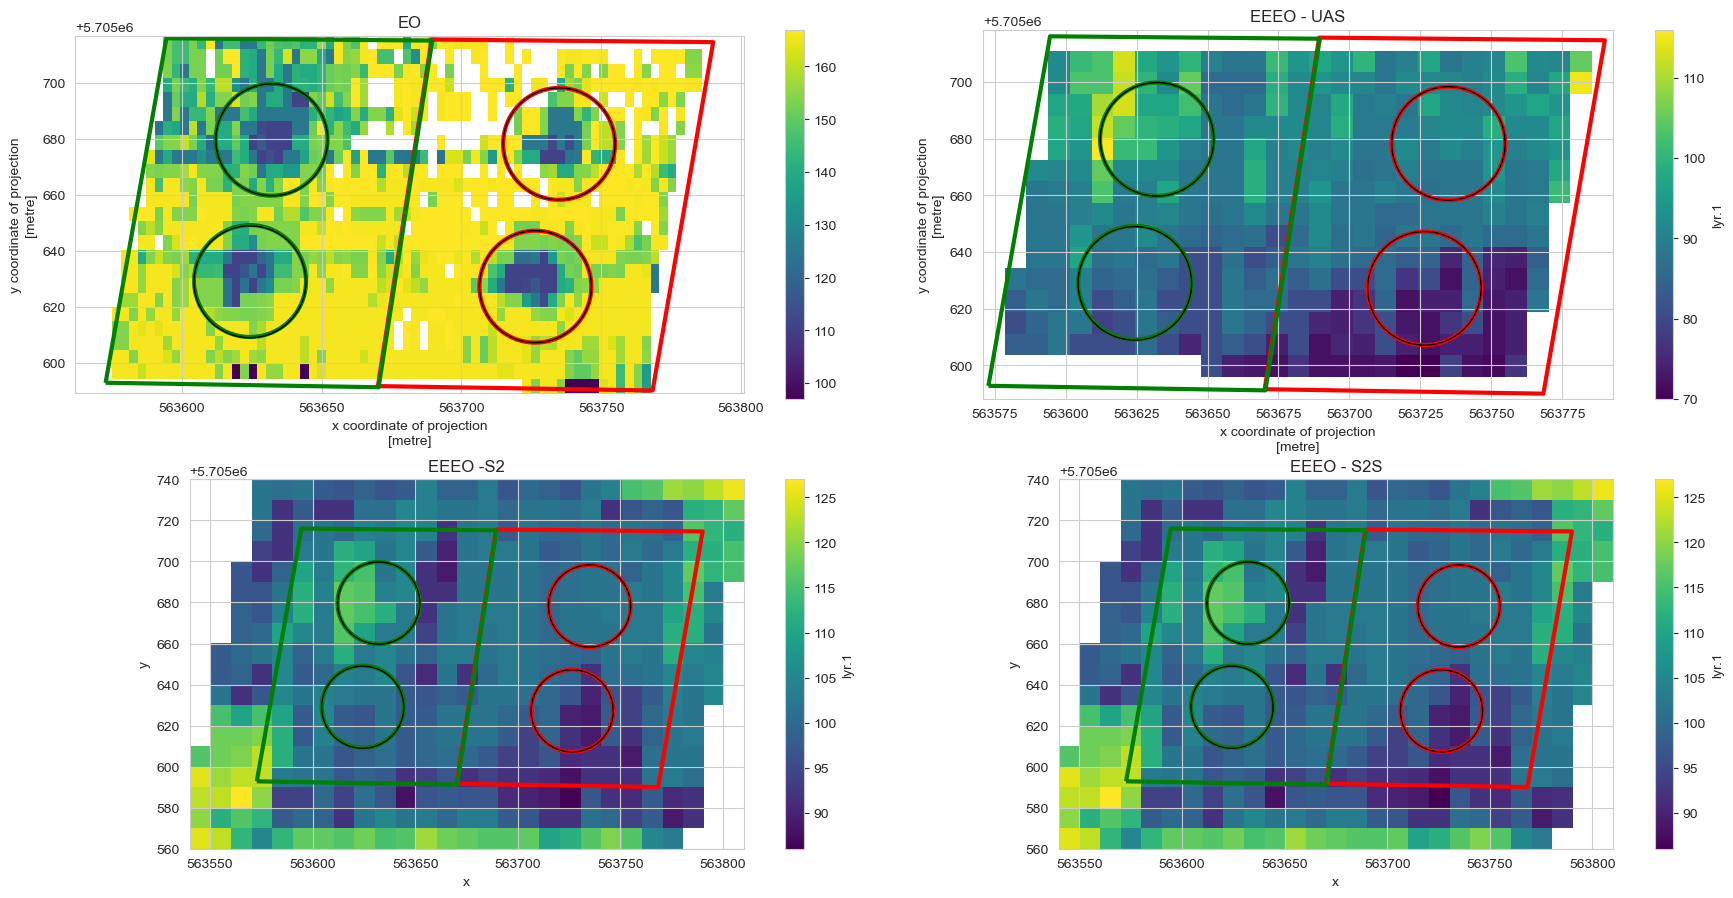

In [9]:
# Create a figure with a 2x3 subplot grid
fig = plt.figure(figsize=(18, 9))

# Create a gridspec with 2 columns and 3 rows
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1])

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

# Observation
obs_rp.isel(band=0).plot.imshow(ax=ax1, cmap="viridis")
treated_roi.boundary.plot(ax=ax1, edgecolor='red', linewidth=3)
untreated_roi.boundary.plot(ax=ax1, edgecolor='green', linewidth=3)

treated_ino.boundary.plot(ax=ax1, edgecolor='black', linewidth=1)
untreated_ino.boundary.plot(ax=ax1, edgecolor='black', linewidth=1)

ax1.set_title("EO")

# UAS
uav_rp.isel(band=0).plot.imshow(ax=ax2, cmap="viridis")
treated_roi.boundary.plot(ax=ax2, edgecolor='red', linewidth=3)
untreated_roi.boundary.plot(ax=ax2, edgecolor='green', linewidth=3)

treated_ino.boundary.plot(ax=ax2, edgecolor='black', linewidth=1)
untreated_ino.boundary.plot(ax=ax2, edgecolor='black', linewidth=1)

ax2.set_title("EEEO - UAS")

# S2
s2.isel(band=0).plot.imshow(ax=ax3, cmap="viridis")
treated_roi.boundary.plot(ax=ax3, edgecolor='red', linewidth=3)
untreated_roi.boundary.plot(ax=ax3, edgecolor='green', linewidth=3)

treated_ino.boundary.plot(ax=ax3, edgecolor='black', linewidth=1)
untreated_ino.boundary.plot(ax=ax3, edgecolor='black', linewidth=1)

ax3.set_title("EEEO -S2")

# S2S
s2s.isel(band=0).plot.imshow(ax=ax4, cmap="viridis")
treated_roi.boundary.plot(ax=ax4, edgecolor='red', linewidth=3)
untreated_roi.boundary.plot(ax=ax4, edgecolor='green', linewidth=3)

treated_ino.boundary.plot(ax=ax4, edgecolor='black', linewidth=1)
untreated_ino.boundary.plot(ax=ax4, edgecolor='black', linewidth=1)

ax4.set_title("EEEO - S2S")

# Layout so plots do not overlap
fig.tight_layout()
plt.savefig(os.path.join(out, f"{current_date}_plot_vectorcheck_eo.png"), dpi=600, bbox_inches='tight')
plt.show()

### 5. Extract EO values

In [10]:
def extract_raster_data(uas_1_rp, treated_roi, untreated_roi, treated_ino, untreated_ino, df_name="df_", value_column="values"):
    extractions = [
        (treated_roi,    "treated",   "non-inoculated"),
        (untreated_roi,  "untreated", "non-inoculated"),
        (treated_ino,    "treated",   "inoculated"),
        (untreated_ino,  "untreated", "inoculated")
    ]

    dfs = []

    for poly, treatment, region in extractions:
        clipped = uas_1_rp.rio.clip(poly.geometry, poly.crs, drop=True).isel(band=0)
        values = clipped.values.flatten()
        mask = ~np.isnan(values)
        values = values[mask]

        y_coords, x_coords = np.meshgrid(clipped['y'].values, clipped['x'].values, indexing='ij')
        x_flat = x_coords.flatten()[mask]
        y_flat = y_coords.flatten()[mask]

        df = pd.DataFrame({
            "x": x_flat,
            "y": y_flat,
            value_column: values,
            "treatment": treatment,
            "area": region,
            "source": df_name
        })

        dfs.append(df)

    df = pd.concat(dfs, ignore_index=True)
    return df

In [11]:
df_obs = extract_raster_data(obs_rp, treated_roi, untreated_roi, treated_ino, untreated_ino, df_name="observation", value_column="das")
df_obs

,x,y,das,treatment,area,source
0,563689.687276,5.705714e+06,154.0,treated,non-inoculated,observation
1,563692.743051,5.705714e+06,167.0,treated,non-inoculated,observation
2,563695.798827,5.705714e+06,167.0,treated,non-inoculated,observation
3,563698.854602,5.705714e+06,166.0,treated,non-inoculated,observation
4,563701.910378,5.705714e+06,166.0,treated,non-inoculated,observation
...,...,...,...,...,...,...
1357,563622.460218,5.705612e+06,166.0,untreated,inoculated,observation
1358,563625.515993,5.705612e+06,154.0,untreated,inoculated,observation
1359,563628.571769,5.705612e+06,158.0,untreated,inoculated,observation
1360,563631.627544,5.705612e+06,166.0,untreated,inoculated,observation


### 6. Extract EEEO - UAS values

In [12]:
df_uas = extract_raster_data(uav_rp, treated_roi, untreated_roi, treated_ino, untreated_ino, df_name="uas", value_column="das")
df_uas

,x,y,das,treatment,area,source
0,563689.494159,5.705707e+06,97.0,treated,non-inoculated,uas
1,563697.152044,5.705707e+06,94.0,treated,non-inoculated,uas
2,563704.809929,5.705707e+06,100.0,treated,non-inoculated,uas
3,563712.467814,5.705707e+06,88.0,treated,non-inoculated,uas
4,563720.125699,5.705707e+06,90.0,treated,non-inoculated,uas
...,...,...,...,...,...,...
352,563635.888963,5.705623e+06,81.0,untreated,inoculated,uas
353,563612.915308,5.705615e+06,79.0,untreated,inoculated,uas
354,563620.573193,5.705615e+06,81.0,untreated,inoculated,uas
355,563628.231078,5.705615e+06,88.0,untreated,inoculated,uas


### 7. Extract EEEO - S2 values

In [13]:
df_s2 = extract_raster_data(s2, treated_roi, untreated_roi, treated_ino, untreated_ino, df_name="s2", value_column="das")
df_s2

,x,y,das,treatment,area,source
0,563695.0,5705715.0,98.0,treated,non-inoculated,s2
1,563705.0,5705715.0,102.0,treated,non-inoculated,s2
2,563715.0,5705715.0,100.0,treated,non-inoculated,s2
3,563725.0,5705715.0,100.0,treated,non-inoculated,s2
4,563735.0,5705715.0,102.0,treated,non-inoculated,s2
...,...,...,...,...,...,...
246,563625.0,5705625.0,97.0,untreated,inoculated,s2
247,563635.0,5705625.0,102.0,untreated,inoculated,s2
248,563615.0,5705615.0,100.0,untreated,inoculated,s2
249,563625.0,5705615.0,99.0,untreated,inoculated,s2


### 8. Extract EEEO - S2S values

In [14]:
df_s2s = extract_raster_data(s2s, treated_roi, untreated_roi, treated_ino, untreated_ino, df_name="s2s", value_column="das")
df_s2s

,x,y,das,treatment,area,source
0,563695.0,5705715.0,98.0,treated,non-inoculated,s2s
1,563705.0,5705715.0,102.0,treated,non-inoculated,s2s
2,563715.0,5705715.0,100.0,treated,non-inoculated,s2s
3,563725.0,5705715.0,100.0,treated,non-inoculated,s2s
4,563735.0,5705715.0,102.0,treated,non-inoculated,s2s
...,...,...,...,...,...,...
246,563625.0,5705625.0,97.0,untreated,inoculated,s2s
247,563635.0,5705625.0,102.0,untreated,inoculated,s2s
248,563615.0,5705615.0,100.0,untreated,inoculated,s2s
249,563625.0,5705615.0,99.0,untreated,inoculated,s2s


### 9. Concatenate and clean dataframes

In [15]:
# Concatenate the individual DataFrames (df_s2_prediction, df_uav_prediction, etc.)
df_all = pd.concat([df_obs, df_uas, df_s2, df_s2s], ignore_index=True)
df_all

,x,y,das,treatment,area,source
0,563689.687276,5.705714e+06,154.0,treated,non-inoculated,observation
1,563692.743051,5.705714e+06,167.0,treated,non-inoculated,observation
2,563695.798827,5.705714e+06,167.0,treated,non-inoculated,observation
3,563698.854602,5.705714e+06,166.0,treated,non-inoculated,observation
4,563701.910378,5.705714e+06,166.0,treated,non-inoculated,observation
...,...,...,...,...,...,...
2216,563625.000000,5.705625e+06,97.0,untreated,inoculated,s2s
2217,563635.000000,5.705625e+06,102.0,untreated,inoculated,s2s
2218,563615.000000,5.705615e+06,100.0,untreated,inoculated,s2s
2219,563625.000000,5.705615e+06,99.0,untreated,inoculated,s2s


In [16]:

# Calculate the mean of the raster values
#mean_obs_das = obs_rp.mean().values.item()  # This will give you the mean DAS value
#print(f"Mean Days After Sowing: {mean_obs_das}")
# Define the sowing date
sowing_date = pd.to_datetime("2022-03-31")

# Convert "das" to actual dates
df_all["date"] = sowing_date + pd.to_timedelta(df_all["das"], unit="D")
df_untreated = df_all[df_all["treatment"] == "untreated"]

# Calculate the mean oberved epidemic onset at field level
mean_obs = df_untreated["das"].mean()
mean_obs = sowing_date + timedelta(days=mean_obs)

# Define onset dates
predicted_onset = pd.to_datetime("2022-08-19")
observed_onset = mean_obs.date() 
canopy_closure = pd.to_datetime("2022-07-30")


# Calculate the Days After Sowing (DAS) for the epidemic onset date
epidemic_onset_das = (predicted_onset - sowing_date).days



df_all.to_csv(os.path.join(out, f"{current_date}_fulldf_eo_cercospoRa.csv"), index=False)

print(f"Field-level EO (average untreated): {observed_onset}")
print(f"Field-level EEEO (CLS Model): {predicted_onset}")
print(f"Field-level canopy closure (observed): {canopy_closure}")

Field-level EO (average untreated): 2022-08-10
Field-level EEEO (CLS Model): 2022-08-19 00:00:00
Field-level canopy closure (observed): 2022-07-30 00:00:00


In [17]:
df_untreated

,x,y,das,treatment,area,source,date
487,563594.958240,5.705714e+06,153.0,untreated,non-inoculated,observation,2022-08-31
488,563598.014015,5.705714e+06,146.0,untreated,non-inoculated,observation,2022-08-24
489,563601.069791,5.705714e+06,145.0,untreated,non-inoculated,observation,2022-08-23
490,563604.125566,5.705714e+06,153.0,untreated,non-inoculated,observation,2022-08-31
491,563607.181341,5.705714e+06,144.0,untreated,non-inoculated,observation,2022-08-22
...,...,...,...,...,...,...,...
2216,563625.000000,5.705625e+06,97.0,untreated,inoculated,s2s,2022-07-06
2217,563635.000000,5.705625e+06,102.0,untreated,inoculated,s2s,2022-07-11
2218,563615.000000,5.705615e+06,100.0,untreated,inoculated,s2s,2022-07-09
2219,563625.000000,5.705615e+06,99.0,untreated,inoculated,s2s,2022-07-08


### 10. Summarize EO (untreated) data

In [18]:
# Group and summarize
summary = df_untreated.groupby(['area', 'source'])['das'].describe().round(2)

# Optional: reset index for flat table display
summary = summary.reset_index()

# Save the summary to a CSV file
summary.to_csv(os.path.join(out, f"{current_date}_summary_desc_stats_eo_cercospoRa.csv"), index=False)

# Display the summary (optional)
summary

,area,source,count,mean,std,min,25%,50%,75%,max
0,inoculated,observation,162.0,139.88,17.23,111.0,125.00,140.0,154.0,167.0
1,inoculated,s2,27.0,105.52,5.94,97.0,102.00,103.0,107.5,117.0
2,inoculated,s2s,27.0,105.52,5.94,97.0,102.00,103.0,107.5,117.0
3,inoculated,uas,44.0,92.07,8.74,79.0,86.75,90.0,97.0,116.0
4,non-inoculated,observation,564.0,156.94,12.08,97.0,153.00,161.0,166.0,167.0
5,non-inoculated,s2,99.0,101.79,6.15,89.0,98.00,102.0,103.5,123.0
6,non-inoculated,s2s,99.0,101.79,6.15,89.0,98.00,102.0,103.5,123.0
7,non-inoculated,uas,130.0,89.54,7.13,73.0,86.00,88.0,92.0,113.0


### 11. Verify position of extracted coordinates

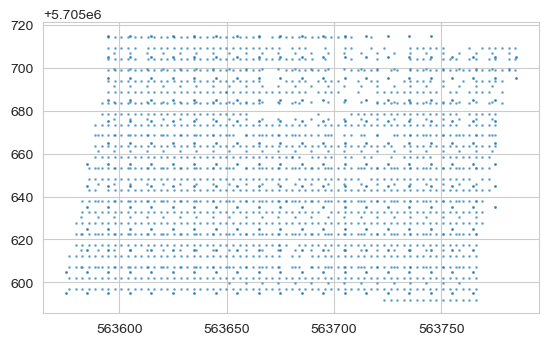

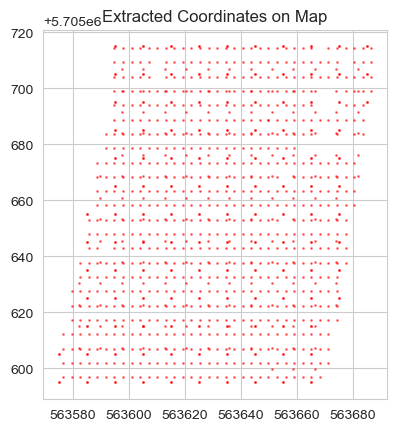

In [19]:
# Create geometry column from x and y
geometry = [Point(xy) for xy in zip(df_all["x"], df_all["y"])]
geometry_un = [Point(xy) for xy in zip(df_untreated["x"], df_untreated["y"])]
gdf = gpd.GeoDataFrame(df_all, geometry=geometry, crs="EPSG:32633")  # Replace with your CRS
gdf_un = gpd.GeoDataFrame(df_untreated, geometry=geometry_un, crs="EPSG:32633")  # Replace with your CRS
# Plot
gdf.plot(markersize=1, alpha=0.5)
gdf_un.plot(markersize=1, alpha=0.5, color="red")
plt.title("Extracted Coordinates on Map")
plt.show()

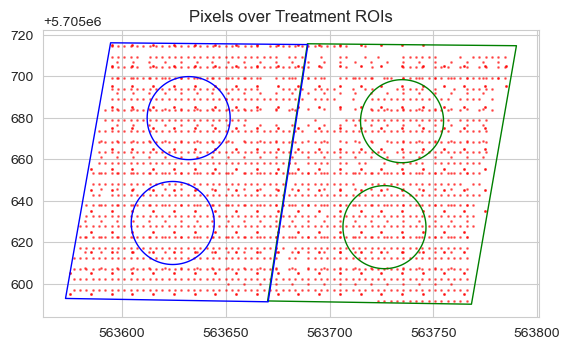

In [20]:
base = gdf.plot(markersize=1, alpha=0.5, color='red')
treated_roi.plot(ax=base, facecolor="none", edgecolor="green")
untreated_roi.plot(ax=base, facecolor="none", edgecolor="blue")
plt.title("Pixels over Treatment ROIs")
plt.show()

### 12. Visualize untreated EO and EEEO data

In [21]:
# Inoculated Area

median_obs_ino = summary.loc[
    (summary['area'] == 'inoculated') & (summary['source'] == 'observation'), '50%'
].values[0]

median_uas_ino = summary.loc[
    (summary['area'] == 'inoculated') & (summary['source'] == 'uas'), '50%'
].values[0]

median_s2_ino = summary.loc[
    (summary['area'] == 'inoculated') & (summary['source'] == 's2'), '50%'
].values[0]

median_s2s_ino = summary.loc[
    (summary['area'] == 'inoculated') & (summary['source'] == 's2s'), '50%'
].values[0]

# Non-inoculated Area

median_obs_nino = summary.loc[
    (summary['area'] == 'non-inoculated') & (summary['source'] == 'observation'), '50%'
].values[0]

median_uas_nino = summary.loc[
    (summary['area'] == 'non-inoculated') & (summary['source'] == 'uas'), '50%'
].values[0]

median_s2_nino = summary.loc[
    (summary['area'] == 'non-inoculated') & (summary['source'] == 's2'), '50%'
].values[0]

median_s2s_nino = summary.loc[
    (summary['area'] == 'non-inoculated') & (summary['source'] == 's2s'), '50%'
].values[0]

print(f"Median, observed, inoculated: {median_obs_ino} das")
print(f"Median, UAS, inoculated: {median_uas_ino} das")
print(f"Median, S2, inoculated: {median_s2_ino} das")
print(f"Median, S2S, inoculated: {median_s2s_ino} das")

print(f"Median, observed, non-inoculated: {median_obs_nino} das")
print(f"Median, UAS, non-inoculated: {median_uas_nino} das")
print(f"Median, S2, non-inoculated: {median_s2_nino} das")
print(f"Median, S2S, non-inoculated: {median_s2s_nino} das")


Median, observed, inoculated: 140.0 das
Median, UAS, inoculated: 90.0 das
Median, S2, inoculated: 103.0 das
Median, S2S, inoculated: 103.0 das
Median, observed, non-inoculated: 161.0 das
Median, UAS, non-inoculated: 88.0 das
Median, S2, non-inoculated: 102.0 das
Median, S2S, non-inoculated: 102.0 das


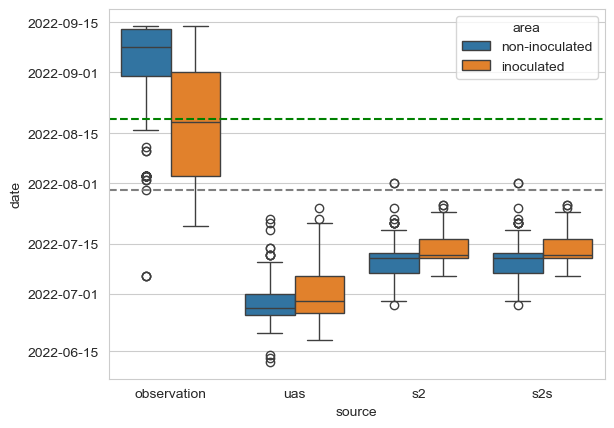

In [22]:
# Ensure that 'date' column is of datetime type
df_untreated.loc[:, 'date'] = pd.to_datetime(df_untreated['date'])

# Boxplot with date on the y-axis

sns.boxplot(x='source', y='date', hue="area", data=df_untreated)

# Add vertical lines
plt.axhline(canopy_closure, color='grey', linestyle='--') # canopy closure
plt.axhline(predicted_onset, color='green', linestyle='--') # field-level EEEO

In [23]:
df_uas = df_untreated[df_untreated["source"] == "uas"]
df_s2 = df_untreated[df_untreated["source"] == "s2"]
df_s2s = df_untreated[df_untreated["source"] == "s2s"]
df_obs = df_untreated[df_untreated["source"] == "observation"]

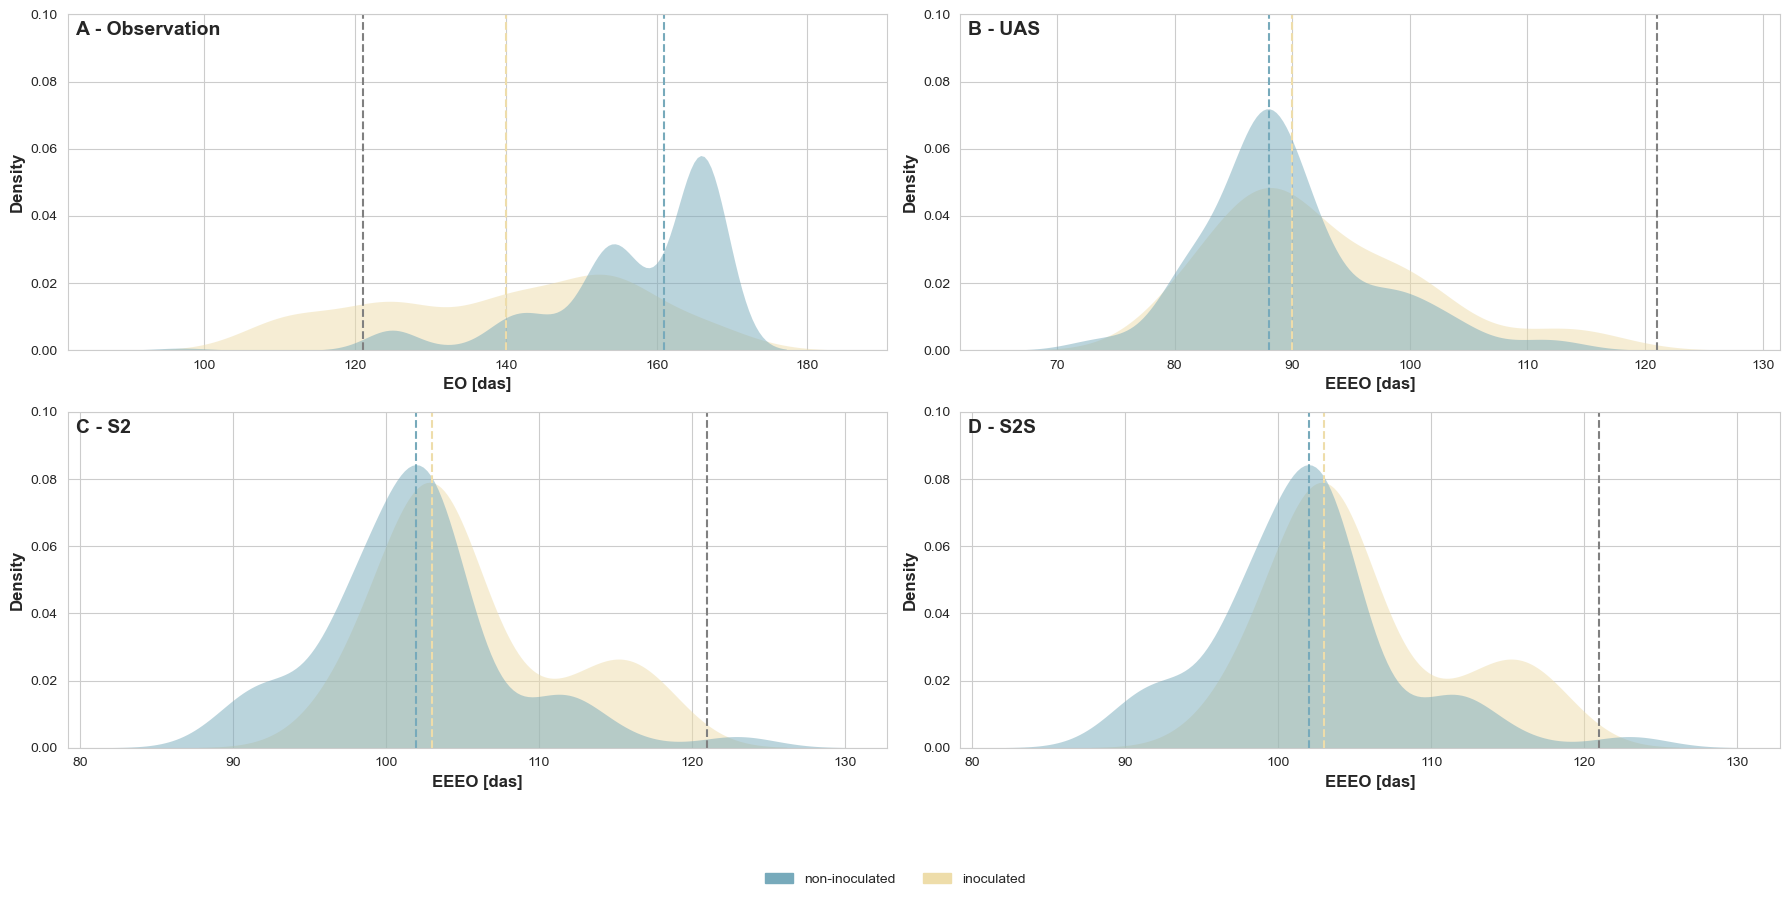

In [24]:
sns.set_style("whitegrid")

# Create a figure with a 2x3 subplot grid
fig = plt.figure(figsize=(18, 9))

# Create a gridspec with 2 columns and 3 rows
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1])

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

# Get unique regions
area = df_uas["area"].unique()
# Generate palette (same as your KDE)
palette = sns.color_palette("blend:#7AB,#EDA", n_colors=len(area))
# Map region names to colors
area_colors = dict(zip(area, palette))


# PLOT Observation

sns.kdeplot(data=df_obs, x="das", hue="area", fill=True, common_norm=False, palette=area_colors,
        alpha=0.5, linewidth=0, ax=ax1, legend=False)

ax1.set_ylim(0, 0.1)

# Add vertical lines to axs[0]
ax1.axvline(121, ymin=0, ymax=1, color='grey', linestyle='--') # canopy closure

ax1.axvline(median_obs_nino, ymin=0, ymax=1, color=area_colors[area[0]], linestyle='--') # non-inoculated
ax1.axvline(median_obs_ino, ymin=0, ymax=1, color=area_colors[area[1]], linestyle='--') # inoculated

# Add letter label to upper-left of axs[0]
ax1.text(
    0.01, 0.98, 'A - Observation', transform=ax1.transAxes,
    fontsize=14, fontweight='bold', va='top', ha='left'
)

ax1.set_ylabel("Density", fontsize=12, fontweight='bold')
ax1.set_xlabel("EO [das]", fontsize=12, fontweight='bold')

# PLOT UAS

sns.kdeplot(data=df_uas, x="das", hue="area", fill=True, common_norm=False, palette=area_colors,
        alpha=0.5, linewidth=0, ax=ax2, legend=False)

ax2.set_ylim(0, 0.1)

# Add vertical lines to axs[0]
ax2.axvline(121, ymin=0, ymax=1, color='grey', linestyle='--') # canopy closure

ax2.axvline(median_uas_nino, ymin=0, ymax=1, color=area_colors[area[0]], linestyle='--') # non-inoculated
ax2.axvline(median_uas_ino, ymin=0, ymax=1, color=area_colors[area[1]], linestyle='--') # inoculated

# Add letter label to upper-left of axs[0]
ax2.text(
    0.01, 0.98, 'B - UAS', transform=ax2.transAxes,
    fontsize=14, fontweight='bold', va='top', ha='left'
)

ax2.set_ylabel("Density", fontsize=12, fontweight='bold')
ax2.set_xlabel("EEEO [das]", fontsize=12, fontweight='bold')

# PLOT S2

sns.kdeplot(data=df_s2, x="das", hue="area", fill=True, common_norm=False, palette=area_colors,
        alpha=0.5, linewidth=0, ax=ax3, legend=False)

ax3.set_ylim(0, 0.1)

# Add vertical lines to axs[0]
ax3.axvline(121, ymin=0, ymax=1, color='grey', linestyle='--') # canopy closure

ax3.axvline(median_s2_nino, ymin=0, ymax=1, color=area_colors[area[0]], linestyle='--') # non-inoculated
ax3.axvline(median_s2_ino, ymin=0, ymax=1, color=area_colors[area[1]], linestyle='--') # inoculated

# Add letter label to upper-left of axs[0]
ax3.text(
    0.01, 0.98, 'C - S2', transform=ax3.transAxes,
    fontsize=14, fontweight='bold', va='top', ha='left'
)

ax3.set_ylabel("Density", fontsize=12, fontweight='bold')
ax3.set_xlabel("EEEO [das]", fontsize=12, fontweight='bold')


# PLOT S2S

sns.kdeplot(data=df_s2s, x="das", hue="area", fill=True, common_norm=False, palette=area_colors,
        alpha=0.5, linewidth=0, ax=ax4, legend=False)

ax4.set_ylim(0, 0.1)

# Add vertical lines to axs[0]
ax4.axvline(121, ymin=0, ymax=1, color='grey', linestyle='--') # canopy closure

ax4.axvline(median_s2s_nino, ymin=0, ymax=1, color=area_colors[area[0]], linestyle='--') # non-inoculated
ax4.axvline(median_s2s_ino, ymin=0, ymax=1, color=area_colors[area[1]], linestyle='--') # inoculated

# Add letter label to upper-left of axs[0]
ax4.text(
    0.01, 0.98, 'D - S2S', transform=ax4.transAxes,
    fontsize=14, fontweight='bold', va='top', ha='left'
)

ax4.set_ylabel("Density", fontsize=12, fontweight='bold')
ax4.set_xlabel("EEEO [das]", fontsize=12, fontweight='bold')


# Manually create legend handles
handles = [mpatches.Patch(color=color, label=area) for area, color in area_colors.items()]

# Add one shared legend below both subplots
fig.legend(handles=handles, loc='lower center', ncol=len(area), frameon=False)

# Adjust layout to make space for legend
plt.tight_layout(rect=[0, 0.1, 1, 1])  # Leave room at bottom
plt.savefig(os.path.join(out, f"{current_date}_plot_kde_eo_cercospoRa.png"), dpi=600, bbox_inches='tight')

plt.show()

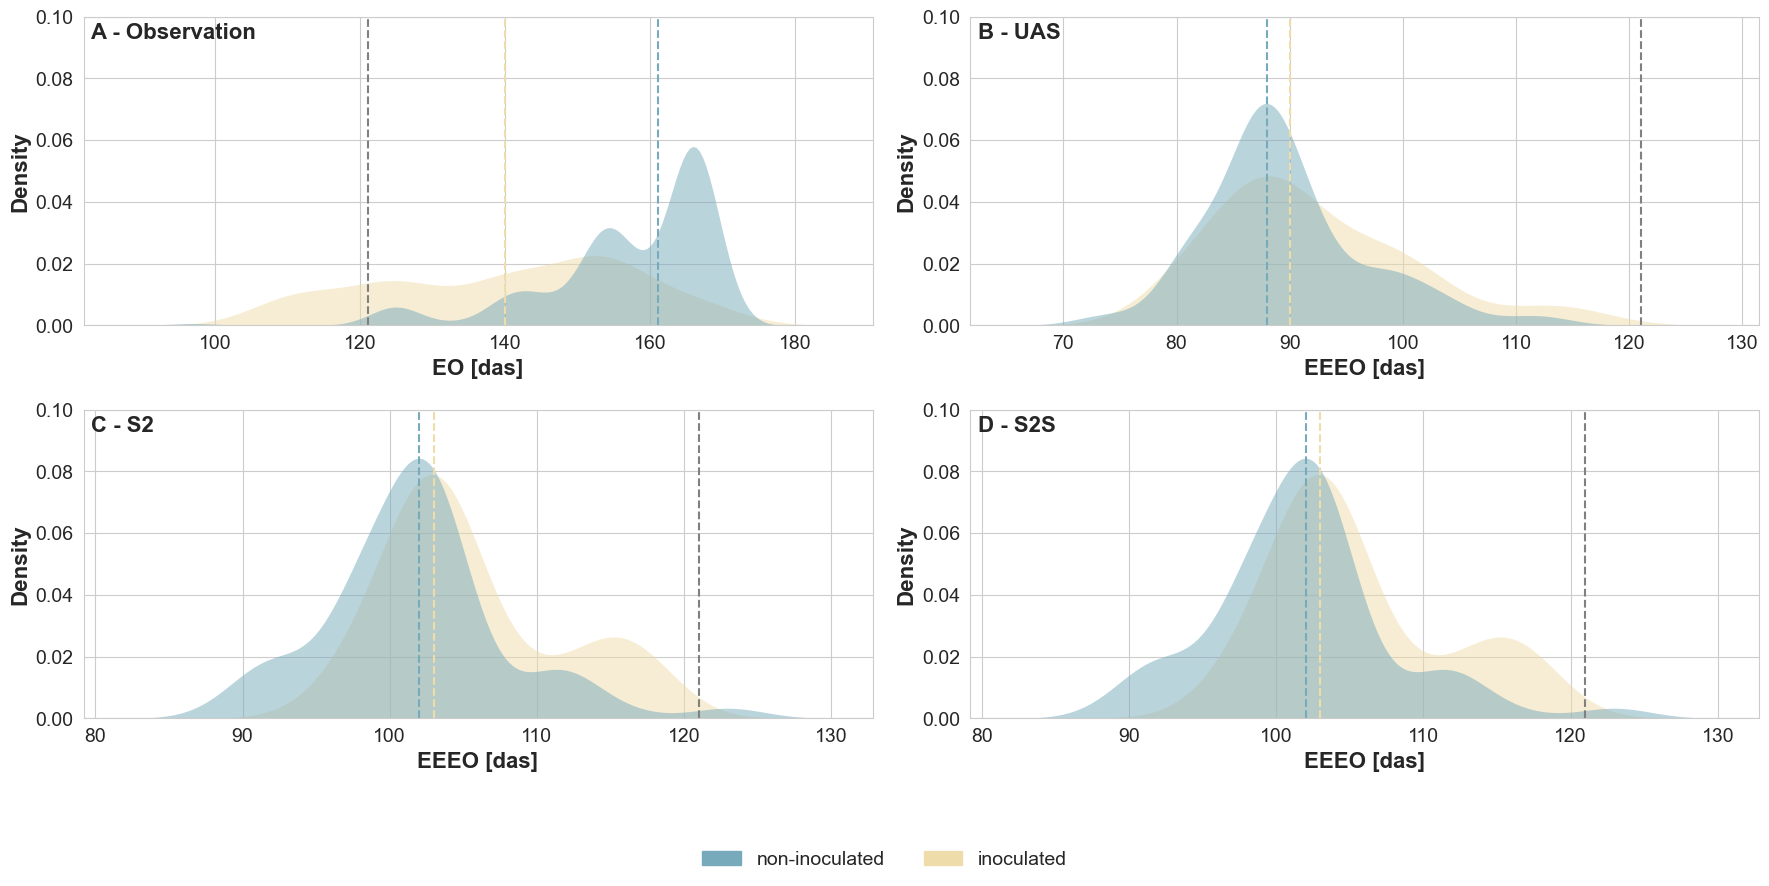

In [25]:
from matplotlib import rcParams

# Set Seaborn style and scale fonts globally
sns.set_style("whitegrid")
rcParams.update({
    'font.size': 16,           # Base font size
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14
})

# Create a figure with a 2x2 grid
fig = plt.figure(figsize=(18, 9))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

# Generate color palette
area = df_uas["area"].unique()
palette = sns.color_palette("blend:#7AB,#EDA", n_colors=len(area))
area_colors = dict(zip(area, palette))

# Define common plot settings
def plot_kde(ax, data, median_nino, median_ino, label, xlabel):
    sns.kdeplot(
        data=data, x="das", hue="area", fill=True, common_norm=False,
        palette=area_colors, alpha=0.5, linewidth=0, ax=ax, legend=False
    )
    ax.set_ylim(0, 0.1)
    ax.axvline(121, color='grey', linestyle='--', label='Canopy Closure')
    ax.axvline(median_nino, color=area_colors[area[0]], linestyle='--')
    ax.axvline(median_ino, color=area_colors[area[1]], linestyle='--')
    ax.text(0.01, 0.98, label, transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top', ha='left')
    ax.set_ylabel("Density", fontsize=16, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=16, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=14)

# Plot each subplot
plot_kde(ax1, df_obs, median_obs_nino, median_obs_ino, 'A - Observation', 'EO [das]')
plot_kde(ax2, df_uas, median_uas_nino, median_uas_ino, 'B - UAS', 'EEEO [das]')
plot_kde(ax3, df_s2, median_s2_nino, median_s2_ino, 'C - S2', 'EEEO [das]')
plot_kde(ax4, df_s2s, median_s2s_nino, median_s2s_ino, 'D - S2S', 'EEEO [das]')

# Create custom legend
handles = [mpatches.Patch(color=color, label=label) for label, color in area_colors.items()]
fig.legend(handles=handles, loc='lower center', ncol=len(area), frameon=False, fontsize=14)

# Adjust layout
plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.savefig(os.path.join(out, f"{current_date}_plot_kde_eo_cercospoRa.png"), dpi=600, bbox_inches='tight')
plt.show()


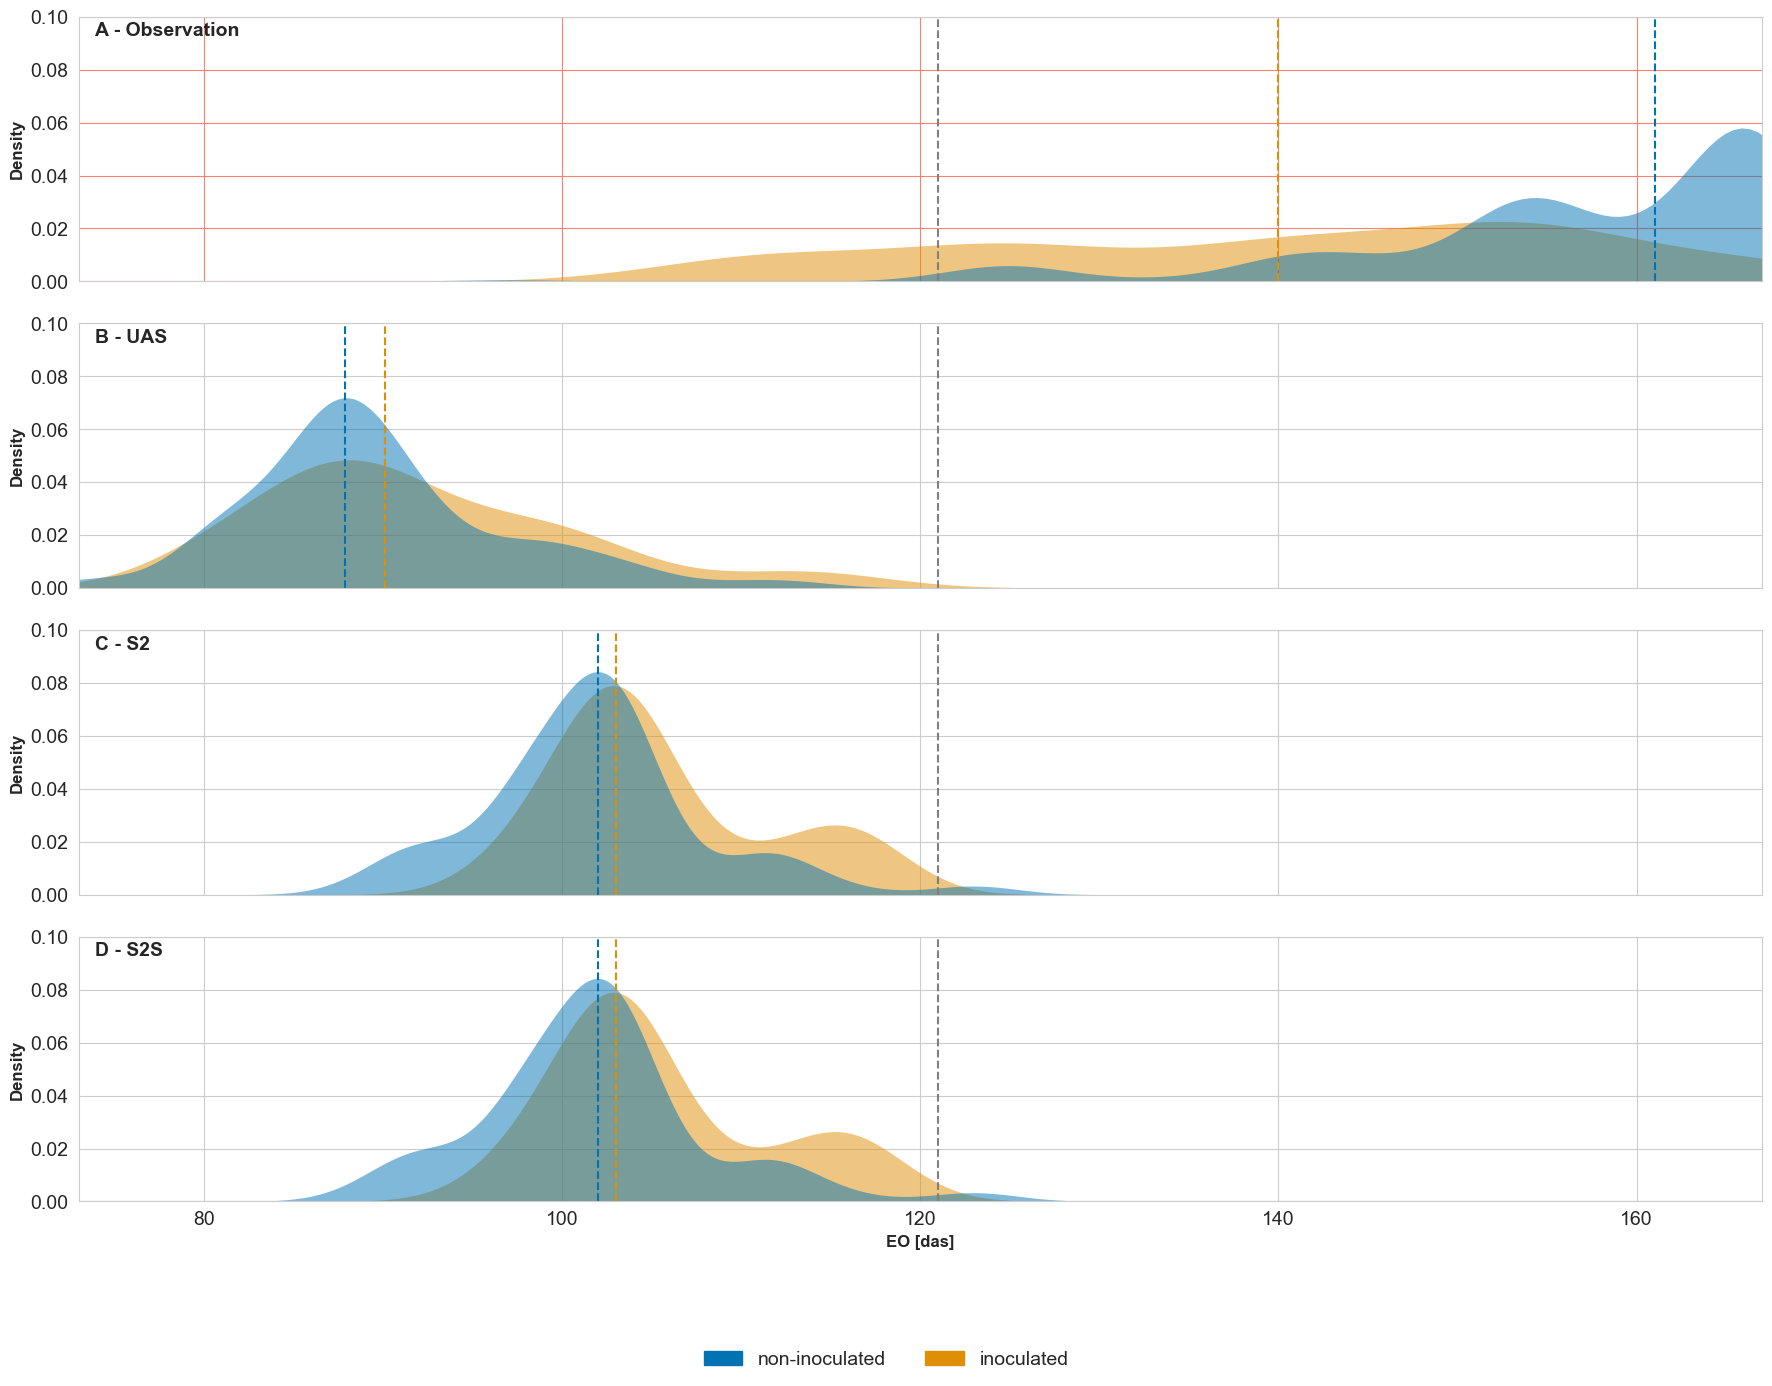

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

sns.set_style("whitegrid")

# Create figure and axes: 4 rows, 1 column, shared x-axis
fig, axs = plt.subplots(4, 1, figsize=(18, 14), sharex=True)

# Combine all 'das' values for min/max limits
x_min = min(df_obs['das'].min(), df_uas['das'].min(), df_s2['das'].min(), df_s2s['das'].min())
x_max = max(df_obs['das'].max(), df_uas['das'].max(), df_s2['das'].max(), df_s2s['das'].max())


area = df_uas["area"].unique()
palette = sns.color_palette("colorblind", 2)
area_colors = dict(zip(area, palette))

# Panel A: Observation
sns.kdeplot(data=df_obs, x="das", hue="area", fill=True, common_norm=False, palette=area_colors,
            alpha=0.5, linewidth=0, ax=axs[0], legend=False)
axs[0].set_ylim(0, 0.1)
axs[0].axvline(121, color='grey', linestyle='--')
axs[0].axvline(median_obs_nino, color=area_colors[area[0]], linestyle='--')
axs[0].axvline(median_obs_ino, color=area_colors[area[1]], linestyle='--')
axs[0].text(0.01, 0.98, 'A - Observation', transform=axs[0].transAxes,
    fontsize=14, fontweight='bold', va='top', ha='left')
axs[0].set_ylabel("Density", fontsize=12, fontweight='bold')
axs[0].grid(color='salmon')

# Panel B: UAS
offset = 0.1  # Adjust to suit data scale

sns.kdeplot(data=df_uas, x="das", hue="area", fill=True, common_norm=False, palette=area_colors,
            alpha=0.5, linewidth=0, ax=axs[1], legend=False)
axs[1].set_ylim(0, 0.1)
axs[1].axvline(121, color='grey', linestyle='--')
axs[1].axvline(median_uas_nino - offset, color=area_colors[area[0]], linestyle='--')
axs[1].axvline(median_uas_ino + offset, color=area_colors[area[1]], linestyle='--')
axs[1].text(0.01, 0.98, 'B - UAS', transform=axs[1].transAxes,
    fontsize=14, fontweight='bold', va='top', ha='left')
axs[1].set_ylabel("Density", fontsize=12, fontweight='bold')

# Panel C: S2
sns.kdeplot(data=df_s2, x="das", hue="area", fill=True, common_norm=False, palette=area_colors,
            alpha=0.5, linewidth=0, ax=axs[2], legend=False)
axs[2].set_ylim(0, 0.1)
axs[2].axvline(121, color='grey', linestyle='--')
axs[2].axvline(median_s2_nino, color=area_colors[area[0]], linestyle='--')
axs[2].axvline(median_s2_ino, color=area_colors[area[1]], linestyle='--')
axs[2].text(0.01, 0.98, 'C - S2', transform=axs[2].transAxes,
    fontsize=14, fontweight='bold', va='top', ha='left')
axs[2].set_ylabel("Density", fontsize=12, fontweight='bold')

# Panel D: S2S
sns.kdeplot(data=df_s2s, x="das", hue="area", fill=True, common_norm=False, palette=area_colors,
            alpha=0.5, linewidth=0, ax=axs[3], legend=False)
axs[3].set_ylim(0, 0.1)
axs[3].axvline(121, color='grey', linestyle='--')
axs[3].axvline(median_s2s_nino, color=area_colors[area[0]], linestyle='--')
axs[3].axvline(median_s2s_ino, color=area_colors[area[1]], linestyle='--')
axs[3].text(0.01, 0.98, 'D - S2S', transform=axs[3].transAxes,
    fontsize=14, fontweight='bold', va='top', ha='left')
axs[3].set_ylabel("Density", fontsize=12, fontweight='bold')
axs[3].set_xlabel("EO [das]", fontsize=12, fontweight='bold')

# Set the same x lim for all
for ax in axs:
    ax.set_xlim(x_min, x_max)

# Manually create legend handles
handles = [mpatches.Patch(color=color, label=area) for area, color in area_colors.items()]

# Add a single shared legend below all panels
fig.legend(handles=handles, loc='lower center', ncol=len(area), frameon=False)
plt.tight_layout(rect=[0, 0.08, 1, 1])  # leaves room for legend
plt.show()


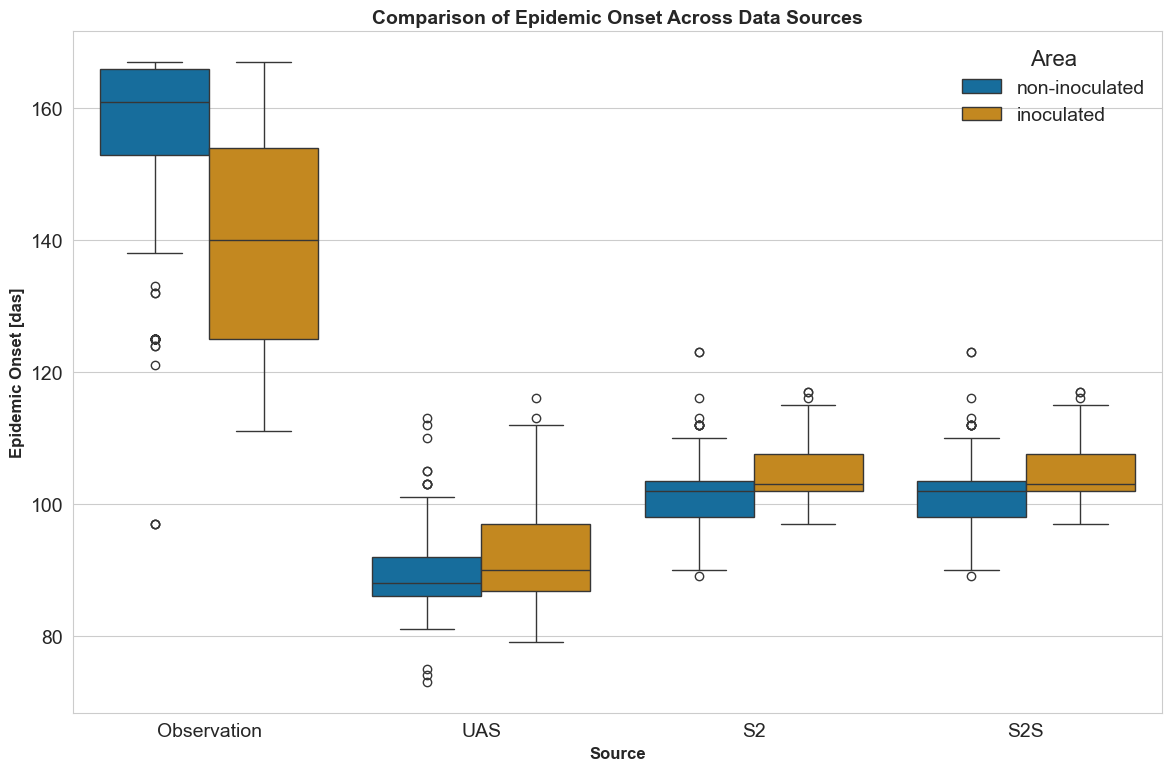

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Combine all datasets into one DataFrame with a 'source' column
df_combined = pd.concat([
    df_obs.assign(source='Observation'),
    df_uas.assign(source='UAS'),
    df_s2.assign(source='S2'),
    df_s2s.assign(source='S2S')
])

# Create a boxplot comparing epidemic onset (das) by source and area
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_combined, x='source', y='das', hue='area', palette=area_colors)
plt.xlabel('Source', fontsize=12, fontweight='bold')
plt.ylabel('Epidemic Onset [das]', fontsize=12, fontweight='bold')
plt.title('Comparison of Epidemic Onset Across Data Sources', fontsize=14, fontweight='bold')
plt.legend(title='Area', frameon=False)
plt.tight_layout()
plt.show()


In [28]:
print("Success.")

Success.
